<a href="https://colab.research.google.com/github/nirmit27/ds-and-ml/blob/main/TensorFlow/Insurance_Forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### CLI commands for importing the **Kaggle** dataset using the API

In [2]:
!pip install -q kaggle
!mkdir -p ~/.kaggle

!cp kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d mirichoi0218/insurance
!unzip insurance.zip -d insurance

Dataset URL: https://www.kaggle.com/datasets/mirichoi0218/insurance
License(s): DbCL-1.0
  0% 0.00/16.0k [00:00<?, ?B/s]
100% 16.0k/16.0k [00:00<00:00, 27.9MB/s]
Archive:  insurance.zip
replace insurance/insurance.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: insurance/insurance.csv  


#### Importing the necessary modules

In [3]:
import os

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.compose import make_column_transformer as column_transformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split as tts

import tensorflow as tf
from tensorflow.keras.utils import plot_model

#### Utility functions

In [13]:
def mse(y_test, y_pred):
  return tf.keras.losses.MSE(y_test, tf.squeeze(y_pred)).numpy()

def mae(y_test, y_pred):
  return tf.keras.losses.MAE(y_test, tf.squeeze(y_pred)).numpy()

# **Medical Insurance Forecast**

| Source | Dataset link |
| ---- | --- |
| Kaggle | [Medical Cost Dataset for Insurance Forecast](https://www.kaggle.com/datasets/mirichoi0218/insurance) |
| GitHub | [Medical Cost Dataset for Insurance Forecast](https://raw.githubusercontent.com/stedy/Machine-Learning-with-R-datasets/master/insurance.csv) |

In [5]:
# GitHub raw CSV import
# df = pd.read_csv("https://raw.githubusercontent.com/stedy/Machine-Learning-with-R-datasets/master/insurance.csv")

# Kaggle dataset import
df = pd.read_csv("insurance/insurance.csv")

df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


### **Identifying** `categorical` and `numerical` columns

In [6]:
cat_cols = []
num_cols = []

for col in df.columns:
  if df[col].dtype == object:
    cat_cols.append(col)
  else:
    num_cols.append(col)

num_cols.pop(-1)

cat_cols, num_cols

(['sex', 'smoker', 'region'], ['age', 'bmi', 'children'])

### **EDA**

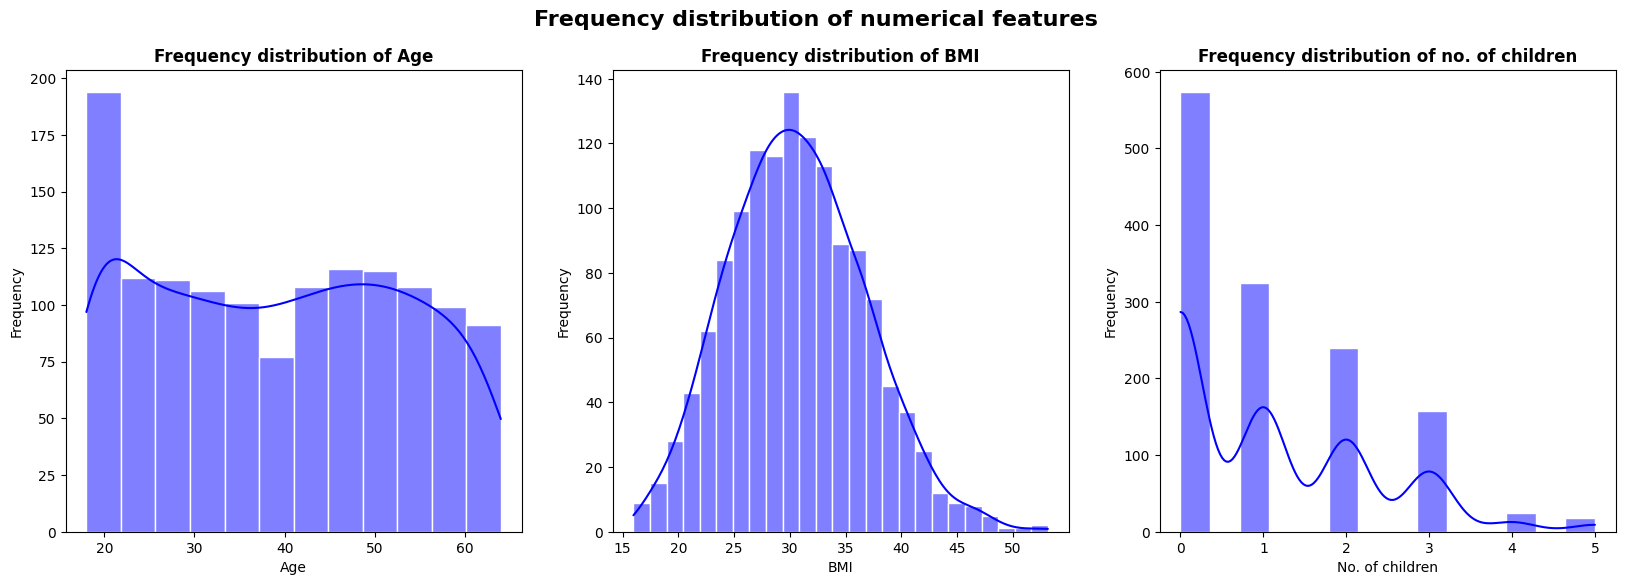

In [7]:
fig, axs = plt.subplots(1, 3, figsize=(20, 6))
fig.suptitle("Frequency distribution of numerical features", fontsize=16, fontweight="bold")

sns.set_theme(style="darkgrid", palette="pastel")

sns.histplot(df["age"], kde=True, color='blue', ax=axs[0])
axs[0].set_title("Frequency distribution of Age", fontweight="bold")
axs[0].set_xlabel("Age")
axs[0].set_ylabel("Frequency")

sns.histplot(df["bmi"], kde=True, color='blue', ax=axs[1])
axs[1].set_title("Frequency distribution of BMI", fontweight="bold")
axs[1].set_xlabel("BMI")
axs[1].set_ylabel("Frequency")

sns.histplot(df["children"], kde=True, color='blue', ax=axs[2])
axs[2].set_title("Frequency distribution of no. of children", fontweight="bold")
axs[2].set_xlabel("No. of children")
axs[2].set_ylabel("Frequency")

plt.show()

### **Preprocessing** the dataset
Normalization and standardization techniques for **faster convergence** applied on the **training** dataset.

In [8]:
ct = column_transformer(
    (StandardScaler(), num_cols),
    (OneHotEncoder(handle_unknown="ignore"), cat_cols)
)

X = df.drop(columns=['charges'])
y = df['charges']

test_size = 0.2
X_train, X_test, y_train, y_test = tts(X, y, test_size=test_size, random_state=44)

X_train_normalized = ct.fit_transform(X_train)
X_test_normalized  = ct.fit_transform(X_test)

### Modelling the **Neural network**
A **linear regression** model for insurance prediction.

In [9]:
tf.random.set_seed(67)

callback = tf.keras.callbacks.EarlyStopping(monitor='mae', patience=3, restore_best_weights=True)

model = tf.keras.Sequential([
    tf.keras.layers.Dense(100, name="layer_1"),
    tf.keras.layers.Dense(10, name="layer_2"),
    tf.keras.layers.Dense(1, name="layer_3"),
])

model.compile(optimizer=tf.keras.optimizers.Adam(), loss='mean_absolute_error', metrics=['mae'])

history = model.fit(X_train_normalized, y_train, epochs=200, verbose=0, callbacks=[callback])

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ layer_1 (Dense)                      │ (None, 100)                 │           1,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer_2 (Dense)                      │ (None, 10)                  │           1,010 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer_3 (Dense)                      │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,665 (26.04 KB)

 Trainable params: 2,221 (8.68 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 4,444 (17.36 KB)

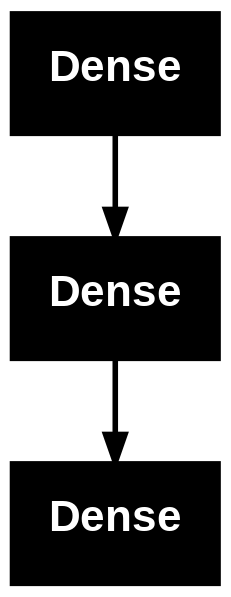

In [10]:
model.build()
model.summary()

plot_model(model)

#### Model **evaluation**

In [11]:
model.evaluate(X_test_normalized, y_test)

print(f"\nMean of testing target   : {y_test.mean():.2f}\nMedian of testing target : {y_test.median():.2f}")

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3600.0249 - mae: 3600.0249  

Mean of testing target   : 12856.26
Median of testing target : 9268.76


In [14]:
y_pred = model.predict(X_test_normalized)

print(f"\nMean Absolute Error : {mae(y_test, y_pred):.2f}\nMean Squared Error  : {mse(y_test, y_pred):.2f}")

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 

Mean Absolute Error : 3267.44
Mean Squared Error  : 43738620.00


#### Plotting the **Training curve**

<Figure size 800x600 with 0 Axes>

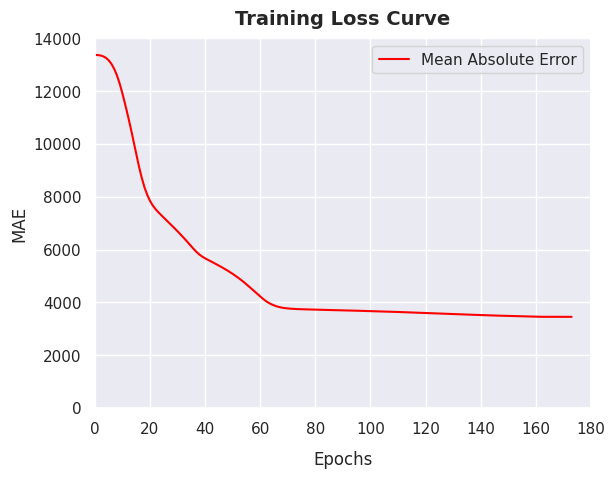

In [25]:
plt.figure(figsize=(8, 6))

model_hist = pd.DataFrame(history.history["mae"])
model_hist.plot(color='red')

plt.title("Training Loss Curve", fontweight='bold', pad=10, fontsize=14)
plt.xlabel("Epochs", labelpad=10)
plt.ylabel("MAE")

plt.axis([0, 180, 0, 14000])
plt.legend(["Mean Absolute Error"])

plt.show()